# The AI-Powered M&A Due Diligence Co-Pilot

### Problem
In any multi-billion dollar M&A deal, the "data room" is a digital swamp of unstructured data: thousands of PDF contracts, scanned documents, and email chains. This critical business information is opaque to traditional analytics, rendering standard databases and reporting tools useless.

As a result, legal teams must resort to a dangerously slow and expensive process of manual review, where highly-paid lawyers spend weeks acting as human keyword scanners. This process is not only inefficient but fraught with risk, as a single missed "poison pill" clause or hidden liability can cost millions and jeopardize the entire deal.
### Solution
Our solution is The Warehouse Co-Pilot, an AI-powered due diligence engine built entirely within Google BigQuery. It introduces a new paradigm by treating the data warehouse as the central nervous system for analysis, bringing powerful AI capabilities directly to the data, rather than moving data out to the AI.

Using BigQuery Object Tables, our system can instantly access and "see" thousands of unstructured documents—PDFs, text files, and even images—directly from Google Cloud Storage. We then use a Remote Model connected to Google's powerful Gemini 2.5 Pro to perform multimodal analysis. This entire workflow is orchestrated with a few lines of SQL, replacing what would traditionally be a complex data engineering pipeline with a simple, scalable query.

The result is the ability to query the unqueryable. The co-pilot reads every document and automatically generates a structured risk report, identifying key clauses like "Change of Control" and their governing law. This transforms the slow, manual review process into a fast, automated, and accurate data analysis task, allowing legal teams to find multi-million dollar risks in minutes, not weeks.

## Architecture

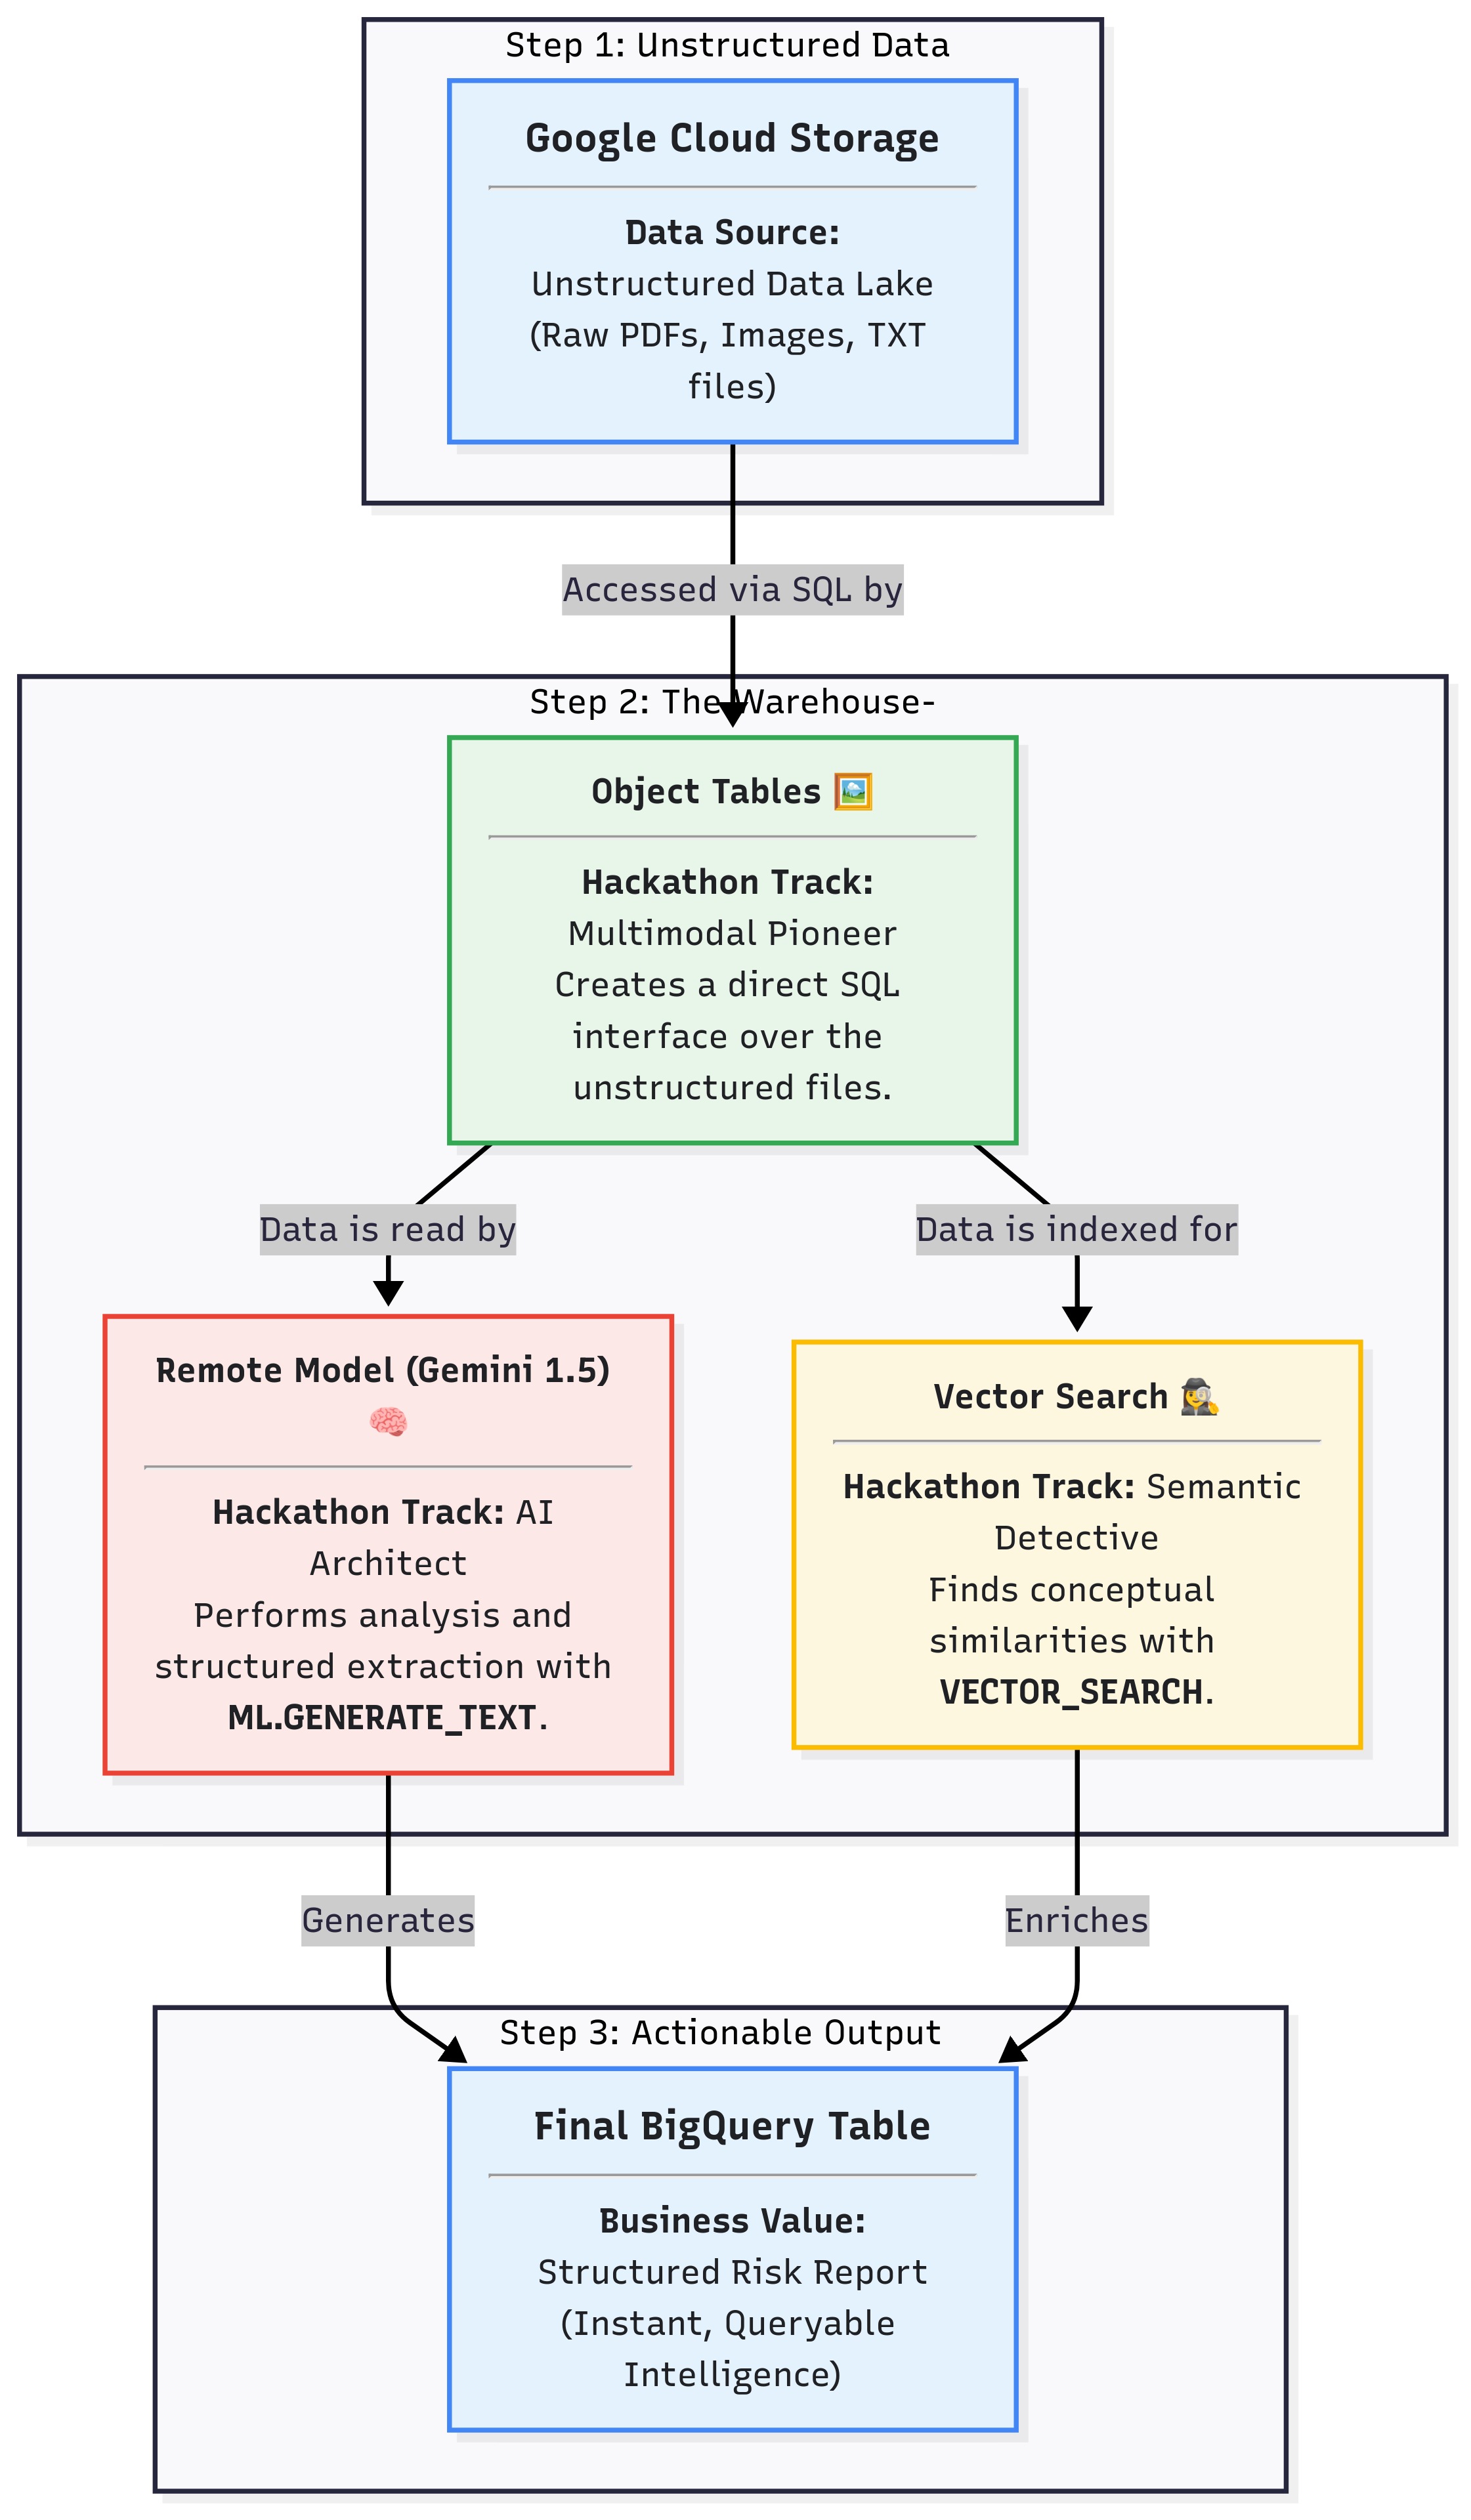

In [1]:
# Manual Authentication Setup (Plan B)
from google.cloud import bigquery
from google.oauth2 import service_account
import json
from kaggle_secrets import UserSecretsClient
import pandas as pd

pd.set_option('display.max_colwidth', None)      # Show full text in each column, no "..."
pd.set_option('display.width', 1000)             # Make the overall table wider
pd.set_option('display.max_columns', None)       # Ensure all columns are always shown

user_secrets = UserSecretsClient()
gcp_credentials_string = user_secrets.get_secret("GCP_CREDENTIALS")
gcp_credentials_json = json.loads(gcp_credentials_string)

# Use the key to create credentials and a BigQuery client
credentials = service_account.Credentials.from_service_account_info(gcp_credentials_json)
project_id = "bigqueryai-471817"
client = bigquery.Client(project=project_id, credentials=credentials)

print(f"Manually connected to Google Cloud Project: {client.project}")

# This is our helper function to run queries
def run_query(query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(query, job_config=job_config)

    try:
        results_df = query_job.to_dataframe()
        return results_df
    except Exception as e:
        # --- MODIFICATION FOR DEBUGGING ---
        # This will now print the exact error message for us.
        print("An error occurred while trying to fetch the results.")
        print(f"--> The specific error is: {e}")
        return pd.DataFrame() # Return an empty DataFrame

ModuleNotFoundError: No module named 'google.cloud'

## Part 1: Semantic Search - The "Semantic Detective"
First, we demonstrate the ability to search for legal *concepts*, not just keywords. We can find documents related to "deal risk" even if they don't use that exact phrase.


**Create Object Tables**

In [ ]:
# We define each SQL command as a Python multi-line string
# and then use our helper function to run each one.

# --- Query 1: Create the PDF object table ---
create_pdf_table_sql = """
CREATE OR REPLACE EXTERNAL TABLE `bigqueryai-471817.ma_due_diligence_data.contracts_pdf`
WITH CONNECTION `us.vertex-ai-connection`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://bigqueryai/Data/*.pdf']
);
"""
# Run the query
run_query(create_pdf_table_sql)

# --- Query 2: Create the TXT object table ---
create_txt_table_sql = """
CREATE OR REPLACE EXTERNAL TABLE `bigqueryai-471817.ma_due_diligence_data.communications_txt`
WITH CONNECTION `us.vertex-ai-connection`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://bigqueryai/Data/*.txt']
);
"""
# Run the query
run_query(create_txt_table_sql)
    
# --- Query 3: Create the PNG object table ---
create_png_table_sql = """
CREATE OR REPLACE EXTERNAL TABLE `bigqueryai-471817.ma_due_diligence_data.screenshots_png`
WITH CONNECTION `us.vertex-ai-connection`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://bigqueryai/Data/*.png']
);
"""
# Run the query
run_query(create_png_table_sql)

print("All three object tables have been created or replaced successfully!")

**Create Remote Models**

In [ ]:
# --- Create the Remote Model for Embeddings (for Semantic Search) ---
create_embedding_model_sql = """
CREATE OR REPLACE MODEL `bigqueryai-471817.ma_due_diligence_data.embedding_model`
  REMOTE WITH CONNECTION `us.vertex-ai-connection`
  OPTIONS (endpoint = 'text-embedding-004');
"""
run_query(create_embedding_model_sql)


# --- Create the Remote Model for Document Analysis (for the Co-Pilot) ---
create_analyzer_model_sql = """
CREATE OR REPLACE MODEL `bigqueryai-471817.ma_due_diligence_data.document_analyzer_model`
  REMOTE WITH CONNECTION `us.vertex-ai-connection`
  OPTIONS (endpoint = 'gemini-2.5-pro');
"""
run_query(create_analyzer_model_sql)

print("Both AI models have been created or replaced successfully!")

**Part 2: The Semantic Search Query**

In [ ]:
# --- Prepare Data for Semantic Search ---

# 1. Create a table to hold our sample text
create_text_table_sql = """
CREATE OR REPLACE TABLE `bigqueryai-471817.ma_due_diligence_data.document_text_content` (
  doc_id STRING,
  content STRING
);
"""
run_query(create_text_table_sql)

# 2. Insert the sample text
insert_text_sql = """
INSERT INTO `bigqueryai-471817.ma_due_diligence_data.document_text_content` (doc_id, content)
VALUES
(
  'email_chain_01.txt',
  'I was reviewing the main credit agreement. My initial analysis of Section 5.02 suggests a very strict "Change of Control" provision. If our acquisition goes through, it looks like their primary lender has the right to demand immediate repayment of the entire loan. This could be a multi-billion dollar poison pill. Requesting your urgent review.'
),
(
  'internal_note_01.txt',
  'The indemnification clause in the main supply contract seems unusually broad. We could be exposed to significant third-party liability with no cap. This represents a major financial danger for our company.'
);
"""
run_query(insert_text_sql)

# 3. Generate and save the embeddings for the sample text
create_embeddings_sql = """
CREATE OR REPLACE TABLE `bigqueryai-471817.ma_due_diligence_data.document_embeddings` AS
SELECT
  doc_id,
  content,
  ml_generate_embedding_result AS embedding
FROM
  ML.GENERATE_EMBEDDING(
    MODEL `bigqueryai-471817.ma_due_diligence_data.embedding_model`,
    TABLE `bigqueryai-471817.ma_due_diligence_data.document_text_content`,
    STRUCT(TRUE AS flatten_json_output)
  );
"""
run_query(create_embeddings_sql)

print("Semantic search data is ready.")

In [ ]:
    # --- Run the Semantic Search ---
    
    semantic_search_sql = """
    SELECT
      base.doc_id,
      base.content,
      distance
    FROM
      VECTOR_SEARCH(
        TABLE `bigqueryai-471817.ma_due_diligence_data.document_embeddings`,
        'embedding',
        (
          SELECT ml_generate_embedding_result
          FROM ML.GENERATE_EMBEDDING(
              MODEL `bigqueryai-471817.ma_due_diligence_data.embedding_model`,
              (SELECT 'significant deal risks and financial exposure' AS content)
          )
        ),
        top_k => 10,
        distance_type => 'COSINE'
      );
    """
    # This will run the query and display the results as a table
    search_results = run_query(semantic_search_sql)
    search_results

**Part 3: The Main Co-Pilot Workflow**

In [ ]:
# --- Main Co-Pilot Step 1: Generate Raw Analysis (Corrected Version) ---

generation_query = """
CREATE OR REPLACE TABLE `bigqueryai-471817.ma_due_diligence_data.model_raw_results` AS

-- CTE 1: Prepare our complete input table with prompts and row numbers
WITH prompt_table AS (
  SELECT
    uri,
    'application/pdf' AS content_type,
    'Analyze the legal document at the URI. Respond ONLY with a valid JSON object inside a json markdown block, containing two keys: "has_change_of_control" (which must be a boolean true or false) and "governing_law" (a string for the jurisdiction, like "State of Delaware", or "Not Found").' AS prompt,
    ROW_NUMBER() OVER() AS row_id
  FROM
    `bigqueryai-471817.ma_due_diligence_data.contracts_pdf`
),
-- CTE 2: Call the AI and get the results with a unique row number
model_outputs AS (
  SELECT
    ml_generate_text_result,
    ROW_NUMBER() OVER() AS row_id
  FROM
    ML.GENERATE_TEXT(
      MODEL `bigqueryai-471817.ma_due_diligence_data.document_analyzer_model`,
      TABLE prompt_table,  -- This is the corrected syntax
      STRUCT(0.0 AS temperature, 1024 AS max_output_tokens)
    )
)
-- Final part of Step 1: Join the inputs and raw outputs and save them
SELECT
  p.uri,
  m.ml_generate_text_result
FROM
  prompt_table p
JOIN
  model_outputs m ON p.row_id = m.row_id;
"""
run_query(generation_query)
print("Main Co-Pilot Step 1 Complete: Raw AI analysis has been generated and saved.")

In [ ]:

parsing_query = r"""
SELECT
  uri AS document_name,
  JSON_VALUE(
    REGEXP_EXTRACT(
      JSON_VALUE(ml_generate_text_result, '$.candidates[0].content.parts[0].text'),
      -- DEFINITIVE REGEX: Using escaped backslashes for BigQuery's SQL engine
      '(?s)```json\\s*\\n(.*)\\n```'
    ),
    '$.has_change_of_control'
  ) AS has_change_of_control_clause,
  JSON_VALUE(
    REGEXP_EXTRACT(
      JSON_VALUE(ml_generate_text_result, '$.candidates[0].content.parts[0].text'),
      -- DEFINITIVE REGEX: Using escaped backslashes for BigQuery's SQL engine
      '(?s)```json\\s*\\n(.*)\\n```'
    ),
    '$.governing_law'
  ) AS governing_law
FROM
  `bigqueryai-471817.ma_due_diligence_data.model_raw_results`;
"""
final_report = run_query(parsing_query)

final_report


### Bonus Feature: Multimodal Analysis - Querying an Image
This co-pilot isn't limited to documents. Because we used a powerful multimodal model (Gemini 1.5 Pro), it can also analyze and understand images directly from Cloud Storage. Here, we ask it to describe a screenshot of a stock chart found in the data room.

In [ ]:
# --- BONUS DEMO: Analyzing an Image---

image_analysis_query = r"""
SELECT
  uri AS image_name,
  JSON_VALUE(ml_generate_text_result, '$.candidates[0].content.parts[0].text') AS ai_description
FROM
  ML.GENERATE_TEXT(
    MODEL `bigqueryai-471817.ma_due_diligence_data.document_analyzer_model`,
    (
      SELECT
        uri,
        'image/png' AS content_type,
        -- FIX 1: Using a more restrictive prompt
        'This image is a screenshot of a legal document clause. Your only task is to accurately transcribe the text visible in the image. Do not add any commentary or description.' AS prompt
      FROM
        `bigqueryai-471817.ma_due_diligence_data.screenshots_png`
      WHERE
        CONTAINS_SUBSTR(uri, 'screenshot_01.png')
    ),
    STRUCT(0.2 AS temperature, 1024 AS max_output_tokens)
  );
"""
image_analysis_report = run_query(image_analysis_query)
image_analysis_report